# Cell 2: 加载数据（混合制热）

In [13]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
data_directory = r"../data/train"
all_data = []
num_trips_to_load = 51

for i in range(1, num_trips_to_load + 1):
    data_path = os.path.join(data_directory, f"trip{i}.npy")
    if os.path.exists(data_path):
        data = np.load(data_path)
        all_data.append(data)
    else:
        raise FileNotFoundError(f"文件缺失: {data_path}")

# 合并所有数据以进行全局归一化统计
all_data_concatenated = np.concatenate(all_data, axis=0)
print(f"合并后all_data：形状{all_data_concatenated.shape}")
print("数据含义: [环境温度, PTC功率, 座舱温度, 压缩机功率, 总功率]")

合并后all_data：形状(255000, 5)
数据含义: [环境温度, PTC功率, 座舱温度, 压缩机功率, 总功率]


# Cell 3: 计算归一化统计量（优化版）


In [14]:
# 计算所有特征的归一化统计量，使用median和mad以鲁棒
normalization_stats = {}
feature_names = ['ambient_temp', 'ptc_power', 'cabin_temp', 'compressor_power', 'total_power']

for i, name in enumerate(feature_names):
    median_val = np.median(all_data_concatenated[:, i])
    mad_val = np.median(np.abs(all_data_concatenated[:, i] - median_val)) or 1e-9  # 使用MAD代替std，更鲁棒
    normalization_stats[f'median_{name}'] = median_val
    normalization_stats[f'mad_{name}'] = mad_val
    print(f"{name}中位数: {median_val:.4f}, MAD: {mad_val:.4f}")

ambient_temp中位数: -5.0014, MAD: 2.5482
ptc_power中位数: 0.0000, MAD: 0.0000
cabin_temp中位数: 20.2300, MAD: 2.4841
compressor_power中位数: 1543.7430, MAD: 257.0817
total_power中位数: 1970.7117, MAD: 333.1952


# Cell 4: 优化的数据预处理

In [15]:
import pandas as pd
import numpy as np

def create_hybrid_heating_features(data, sequence_length, offset, normalization_stats):
    """
    创建混合制热的特征和标签
    返回: input_array, temp_labels, power_labels, physics_data_list
    """
    input_list = []
    label_temp_list = []
    label_total_power_list = []
    physics_data_list = []  # 用于物理约束的原始数据
    
    N = data.shape[0]
    step_size = 5
    if N < sequence_length + offset:
        return [], [], [], []
    
    for j in range(0, N - sequence_length - offset + 1, step_size):
        # 1. 提取输入特征（环境温度、PTC功率、压缩机功率）
        input_features_raw = data[j:j+sequence_length, [0, 1, 3]].copy().astype(np.float32)
        
        # 新增：数据增强，加小噪声
        input_features_raw += np.random.normal(0, 0.01 * np.std(input_features_raw, axis=0), input_features_raw.shape)
        
        # 2. 稳健的归一化（使用median和mad）
        normalized_features = np.zeros_like(input_features_raw)
        normalized_features[:, 0] = (input_features_raw[:, 0] - normalization_stats['median_ambient_temp']) / max(normalization_stats['mad_ambient_temp'], 1e-6)
        normalized_features[:, 1] = (input_features_raw[:, 1] - normalization_stats['median_ptc_power']) / max(normalization_stats['mad_ptc_power'], 1e-6)
        normalized_features[:, 2] = (input_features_raw[:, 2] - normalization_stats['median_compressor_power']) / max(normalization_stats['mad_compressor_power'], 1e-6)
        
        # 3. 添加一阶差分特征
        diff_features = np.diff(normalized_features, axis=0, prepend=normalized_features[0:1,:])
        
        # 4. 滑动窗口统计特征（增大窗口到10）
        window_size = 10
        power_sum = normalized_features[:, 1] + normalized_features[:, 2]
        power_ratio = np.divide(normalized_features[:, 1], normalized_features[:, 2] + 1e-6)
        
        power_sum_ma = pd.Series(power_sum).rolling(window=window_size, min_periods=1).mean().values
        power_ratio_ma = pd.Series(power_ratio).rolling(window=window_size, min_periods=1).mean().values
        
        # 5. 物理启发特征
        temp_gradient = np.gradient(normalized_features[:, 0])
        power_change_rate = np.gradient(power_sum)

        # 6. 新增：滞后总功率特征
        lagged_total_power = np.roll(data[j:j+sequence_length, 4].copy().astype(np.float32), 1)
        lagged_total_power[0] = 0.0
        lagged_total_power_norm = (lagged_total_power - normalization_stats['median_total_power']) / max(normalization_stats['mad_total_power'], 1e-6)
        
        # 7. 组合所有特征 (总共11个特征)
        combined_features = np.column_stack([
            normalized_features,
            diff_features,
            power_sum_ma,
            power_ratio_ma,
            temp_gradient,
            power_change_rate,
            lagged_total_power_norm
        ])
        
        # 8. 提取标签 (原始尺度)
        label_temp = data[j+offset:j+sequence_length+offset, 2]
        label_total_power = data[j+offset:j+sequence_length+offset, 4]
        
        # 9. 提取用于物理约束的原始数据 (字典形式)
        physics_data_raw = {
            'ambient_temp': data[j:j+sequence_length, 0],
            'ptc_power': data[j:j+sequence_length, 1],
            'cabin_temp': data[j:j+sequence_length, 2],
            'compressor_power': data[j:j+sequence_length, 3],
            'total_power_true': data[j+offset:j+sequence_length+offset, 4] # 预测的真实标签
        }
        
        input_list.append(combined_features)
        label_temp_list.append(label_temp)
        label_total_power_list.append(label_total_power)
        physics_data_list.append(physics_data_raw)
    
    return np.array(input_list), np.array(label_temp_list), np.array(label_total_power_list), physics_data_list

# 处理所有数据
sequence_length = 300
offset = 1

all_inputs, all_temp_labels, all_total_power_labels, all_physics_data = [], [], [], []

for data in all_data:
    inputs, temp_labels, power_labels, physics_data = create_hybrid_heating_features(
        data, sequence_length, offset, normalization_stats
    )
    all_inputs.extend(inputs)
    all_temp_labels.extend(temp_labels)
    all_total_power_labels.extend(power_labels)
    all_physics_data.extend(physics_data)

input_array = np.array(all_inputs)
label_temp_array = np.array(all_temp_labels)
label_total_power_array = np.array(all_total_power_labels)

print(f"输入形状: {input_array.shape} (样本数, 序列长, 11特征)")
print(f"座舱温度标签形状: {label_temp_array.shape}")
print(f"总功率标签形状: {label_total_power_array.shape}")
print(f"物理数据样本数: {len(all_physics_data)}")

输入形状: (47940, 300, 11) (样本数, 序列长, 11特征)
座舱温度标签形状: (47940, 300)
总功率标签形状: (47940, 300)
物理数据样本数: 47940


# Cell 5: 优化的数据集和DataLoader


In [16]:
from torch.utils.data import DataLoader, Dataset

class OptimizedHybridHeatingDataset(Dataset):
    def __init__(self, inputs, temp_labels, power_labels, physics_data):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.temp_labels = torch.tensor(temp_labels, dtype=torch.float32)
        self.power_labels = torch.tensor(power_labels, dtype=torch.float32)
        self.physics_data = physics_data

    def __getitem__(self, index):
        # 将物理数据转换为Tensor并返回
        phys_data_tensor = {k: torch.tensor(v, dtype=torch.float32) for k, v in self.physics_data[index].items()}
        return (self.inputs[index], self.temp_labels[index], self.power_labels[index], 
                phys_data_tensor)

    def __len__(self):
        return len(self.inputs)

# 数据集拆分
all_size = len(all_inputs)
indices = np.random.permutation(all_size)

train_size = int(0.8 * all_size)
valid_size = int(0.1 * all_size)

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

# 封装训练、验证和测试数据集
train_dataset = OptimizedHybridHeatingDataset(
    input_array[train_indices],
    label_temp_array[train_indices],
    label_total_power_array[train_indices],
    [all_physics_data[i] for i in train_indices]
)

valid_dataset = OptimizedHybridHeatingDataset(
    input_array[valid_indices],
    label_temp_array[valid_indices],
    label_total_power_array[valid_indices],
    [all_physics_data[i] for i in valid_indices]
)

test_dataset = OptimizedHybridHeatingDataset(
    input_array[test_indices],
    label_temp_array[test_indices],
    label_total_power_array[test_indices],
    [all_physics_data[i] for i in test_indices]
)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print("优化版DataLoader创建完成")

优化版DataLoader创建完成


# Cell 6: 简化的物理约束函数


In [17]:
import torch.nn.functional as F

PHYSICAL_PARAMS = {
    "alpha": 10.0,   # 根据之前的讨论，大幅提高温度权重
    "beta": 0.5,     # 功率权重保持较低
    "gamma_energy": 0.1,
    "gamma_thermal": 0.05,
    "specific_heat_capacity": 1005, "mass_air": 50, "k_base": 8, 
    "surface_area": 3, "efficiency_ptc": 0.95, "efficiency_compressor": 2.8, "dt": 1,
}

def calculate_corrected_loss(predicted_temp, predicted_power, true_temp, true_power, physics_data, params, temp_only=False):
    # 1. 数据损失
    temp_loss = F.mse_loss(predicted_temp.squeeze(-1), true_temp)
    power_loss = F.mse_loss(predicted_power.squeeze(-1) / 1000.0, true_power / 1000.0) if not temp_only else torch.tensor(0.0, device=predicted_temp.device)
    
    # 2. 物理损失
    ambient_temp = physics_data['ambient_temp']
    ptc_power = physics_data['ptc_power']
    cabin_temp = physics_data['cabin_temp']
    compressor_power = physics_data['compressor_power']
    
    # 能量守恒 (忽略 if temp_only)
    known_power_sum = ptc_power + compressor_power
    energy_constraint_loss = F.mse_loss(predicted_power.squeeze(-1), known_power_sum) if not temp_only else torch.tensor(0.0, device=predicted_temp.device)
    
    # 热力学约束 (保留，温度专用)
    Q_loss = params["k_base"] * params["surface_area"] * (predicted_temp.squeeze(-1) - ambient_temp)
    Q_heating = (ptc_power * params["efficiency_ptc"] + compressor_power * params["efficiency_compressor"])
    dT_theoretical = (Q_heating - Q_loss) * params["dt"] / (params["mass_air"] * params["specific_heat_capacity"])
    dT_predicted = predicted_temp.squeeze(-1) - cabin_temp
    thermal_constraint_loss = F.mse_loss(dT_predicted, dT_theoretical)
    
    physics_loss = params["gamma_energy"] * energy_constraint_loss + params["gamma_thermal"] * thermal_constraint_loss

    # 3. 综合损失
    total_loss = (params["alpha"] * temp_loss + 
                  params["beta"] * power_loss + 
                  physics_loss)
    
    return total_loss, temp_loss, power_loss, physics_loss

# Cell 7: 优化的PINN模型架构


In [18]:
import torch.nn as nn

class DynamicDecoupledHybridPINN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=3, dropout=0.1):
        super(DynamicDecoupledHybridPINN, self).__init__()
        
        # 1. 共享编码器: BiLSTM + Self-Attention
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        self.shared_attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  # *2因为是双向LSTM
            num_heads=4, 
            dropout=dropout, 
            batch_first=True
        )
        
        # 2. 任务解耦: 为每个任务创建独立的残差网络块
        self.temp_residual = self._create_residual_block(hidden_size * 2, hidden_size, dropout)
        self.temp_skip = nn.Linear(hidden_size * 2, hidden_size) # 跳跃连接层
        
        self.power_residual = self._create_residual_block(hidden_size * 2, hidden_size, dropout)
        self.power_skip = nn.Linear(hidden_size * 2, hidden_size) # 跳跃连接层

        # 3. 独立的预测头
        self.temp_head = self._create_head(hidden_size, dropout)
        self.power_head = self._create_head(hidden_size, dropout)
        
        # 4. 动态解耦权重 (模型的可学习参数)
        self.decouple_weight_temp = nn.Parameter(torch.tensor(1.0))
        self.decouple_weight_power = nn.Parameter(torch.tensor(1.0))

    def _create_residual_block(self, input_dim, output_dim, dropout):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim, output_dim),
            nn.ReLU()
        )

    def _create_head(self, input_dim, dropout):
        return nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.shared_attention(lstm_out, lstm_out, lstm_out)
        
        # --- 温度任务路径 ---
        temp_res_out = self.temp_residual(attn_out)     # F(x)
        temp_skip_out = self.temp_skip(attn_out)      # Wx
        temp_features = temp_res_out + temp_skip_out
        temp_features = temp_features * self.decouple_weight_temp
        temp_pred = self.temp_head(temp_features)
        
        # --- 功率任务路径 ---
        power_res_out = self.power_residual(attn_out)
        power_skip_out = self.power_skip(attn_out)
        power_features = power_res_out + power_skip_out
        power_features = power_features * self.decouple_weight_power
        power_pred = self.power_head(power_features)
        
        return temp_pred, power_pred

    def update_decouple_weights(self, temp_grad_vec, power_grad_vec, lambda_factor=0.1):
        if temp_grad_vec is not None and power_grad_vec is not None and temp_grad_vec.numel() > 0 and power_grad_vec.numel() > 0:
            cos_sim = F.cosine_similarity(temp_grad_vec, power_grad_vec, dim=0)
            adjust = lambda_factor * (1 - cos_sim).clamp(min=0) 
            self.decouple_weight_temp.data += adjust
            self.decouple_weight_power.data += adjust
            self.decouple_weight_temp.data.clamp_(0.5, 2.0)
            self.decouple_weight_power.data.clamp_(0.5, 2.0)

    def freeze_power_paths(self, freeze=True):
        for param in self.power_residual.parameters():
            param.requires_grad = not freeze
        for param in self.power_skip.parameters():
            param.requires_grad = not freeze
        for param in self.power_head.parameters():
            param.requires_grad = not freeze
        self.decouple_weight_power.requires_grad = not freeze

# 模型初始化
model = DynamicDecoupledHybridPINN(
    input_size=11, 
    hidden_size=256,
    num_layers=3,
    dropout=0.1
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"动态解耦模型已加载到: {device}")
print(f"模型输入特征数: {11}")

动态解耦模型已加载到: cuda
模型输入特征数: 11


# Cell 8: 优化的训练设置


In [19]:

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

train_losses = {'temp': [], 'power': [], 'physics': [], 'total': []}
valid_losses = {'temp': [], 'power': [], 'physics': [], 'total': []}

print("优化器和学习率调度器设置完成。")

优化器和学习率调度器设置完成。


# Cell 9:训练循环


In [ ]:
epochs = 50
best_valid_loss = float('inf')
patience = 15
patience_counter = 0
model_save_path = '../model/best_balanced_hybrid_pinn_v2.pt'

# 权重日志：不改函数的前提下，只能记录“静态权重”（不影响训练）
decouple_weights_log = []
static_loss_weights = {
    "temp": float(PHYSICAL_PARAMS.get("alpha", 1.0)),
    "power": float(PHYSICAL_PARAMS.get("beta", 1.0)),
    "physics": 1.0,  # physics_loss 内部已有 gamma_* 缩放时，这里记 1.0 即可
}

def _align_to_T(x: torch.Tensor, T: int):
    """把序列张量沿时间维对齐到最后 T 步；支持 (B,L)、(B,L,1)、(L,)"""
    if not torch.is_tensor(x):
        return x
    # squeeze last dim if (..., 1)
    if x.dim() >= 2 and x.size(-1) == 1:
        x = x.squeeze(-1)
    # (B,L) 或 (L,)
    if x.dim() == 2:
        return x[:, -T:]
    if x.dim() == 1:
        return x[-T:]
    return x  # 其它形状保持不动

print("\n=== 开始优化版 PINN 训练 ===")
for epoch in range(epochs):
    # --- 训练阶段 ---
    model.train()
    train_temp_loss, train_power_loss, train_physics_loss, train_total_loss = 0.0, 0.0, 0.0, 0.0
    train_count = 0

    for inputs, temp_labels, power_labels, physics_data in train_dataloader:
        inputs = inputs.to(device)
        temp_labels = temp_labels.to(device)
        power_labels = power_labels.to(device)
        physics_data_on_device = {k: v.to(device) for k, v in physics_data.items()}

        optimizer.zero_grad(set_to_none=True)

        temp_pred, power_pred = model(inputs)

        # ===== 关键：对齐长度（pred=90, label=450 -> 切到 90）=====
        T = temp_pred.squeeze(-1).shape[1]

        temp_labels = _align_to_T(temp_labels, T)
        power_labels = _align_to_T(power_labels, T)
        physics_data_on_device = {k: _align_to_T(v, T) for k, v in physics_data_on_device.items()}

        # ✅ 只接 4 个返回值
        total_loss, temp_loss, power_loss, physics_loss = calculate_corrected_loss(
            temp_pred, power_pred,
            temp_labels, power_labels,
            physics_data_on_device, PHYSICAL_PARAMS
        )

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"警告: Epoch {epoch+1} 训练中出现 NaN/Inf 损失，跳过此批次。")
            continue

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_temp_loss += temp_loss.item()
        train_power_loss += power_loss.item()
        train_physics_loss += physics_loss.item()
        train_total_loss += total_loss.item()
        train_count += 1

    # --- 验证阶段 ---
    model.eval()
    valid_temp_loss, valid_power_loss, valid_physics_loss, valid_total_loss = 0.0, 0.0, 0.0, 0.0
    valid_count = 0

    with torch.no_grad():
        for inputs, temp_labels, power_labels, physics_data in valid_dataloader:
            inputs = inputs.to(device)
            temp_labels = temp_labels.to(device)
            power_labels = power_labels.to(device)
            physics_data_on_device = {k: v.to(device) for k, v in physics_data.items()}

            temp_pred, power_pred = model(inputs)

            # ===== 同样对齐长度 =====
            T = temp_pred.squeeze(-1).shape[1]

            temp_labels = _align_to_T(temp_labels, T)
            power_labels = _align_to_T(power_labels, T)
            physics_data_on_device = {k: _align_to_T(v, T) for k, v in physics_data_on_device.items()}

            total_loss, temp_loss, power_loss, physics_loss = calculate_corrected_loss(
                temp_pred, power_pred,
                temp_labels, power_labels,
                physics_data_on_device, PHYSICAL_PARAMS
            )

            if torch.isnan(total_loss) or torch.isinf(total_loss):
                continue

            valid_temp_loss += temp_loss.item()
            valid_power_loss += power_loss.item()
            valid_physics_loss += physics_loss.item()
            valid_total_loss += total_loss.item()
            valid_count += 1

    # --- 记录 loss ---
    avg_train_loss = train_total_loss / max(train_count, 1)
    avg_valid_loss = valid_total_loss / max(valid_count, 1)

    train_losses['total'].append(avg_train_loss)
    train_losses['temp'].append(train_temp_loss / max(train_count, 1))
    train_losses['power'].append(train_power_loss / max(train_count, 1))
    train_losses['physics'].append(train_physics_loss / max(train_count, 1))

    valid_losses['total'].append(avg_valid_loss)
    valid_losses['temp'].append(valid_temp_loss / max(valid_count, 1))
    valid_losses['power'].append(valid_power_loss / max(valid_count, 1))
    valid_losses['physics'].append(valid_physics_loss / max(valid_count, 1))

    scheduler.step()

    print(
        f"Epoch {epoch+1:2d}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )

    # 记录权重日志（静态）
    decouple_weights_log.append({
        "epoch": epoch + 1,
        "温度任务权重": static_loss_weights["temp"],
        "功率任务权重": static_loss_weights["power"],
        "物理约束权重": static_loss_weights["physics"],
    })

    # --- 早停 + 保存 ---
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'normalization_stats': normalization_stats,
            'epoch': epoch,
            'best_loss': best_valid_loss
        }, model_save_path)
        print(f"  -> 验证损失提升, 模型已保存至 {model_save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"早停触发，在第 {epoch+1} 轮停止训练。")
            break

print(f"\n训练完成，最佳验证损失: {best_valid_loss:.4f}")



=== 开始优化版 PINN 训练 ===
Epoch  1/50 | Train Loss: 11434.4676 | Valid Loss: 7907.9190 | LR: 1.00e-03
  -> 验证损失提升, 模型已保存至 ./best_balanced_hybrid_pinn_v2.pt
Epoch  2/50 | Train Loss: 8367.5256 | Valid Loss: 6056.7468 | LR: 9.99e-04
  -> 验证损失提升, 模型已保存至 ./best_balanced_hybrid_pinn_v2.pt
Epoch  3/50 | Train Loss: 7092.2062 | Valid Loss: 8355.8546 | LR: 9.98e-04
Epoch  4/50 | Train Loss: 6874.4487 | Valid Loss: 5842.7884 | LR: 9.96e-04
  -> 验证损失提升, 模型已保存至 ./best_balanced_hybrid_pinn_v2.pt
Epoch  5/50 | Train Loss: 6229.9957 | Valid Loss: 5306.3247 | LR: 9.94e-04
  -> 验证损失提升, 模型已保存至 ./best_balanced_hybrid_pinn_v2.pt
Epoch  6/50 | Train Loss: 5619.0070 | Valid Loss: 3333.2264 | LR: 9.91e-04
  -> 验证损失提升, 模型已保存至 ./best_balanced_hybrid_pinn_v2.pt
Epoch  7/50 | Train Loss: 4888.0617 | Valid Loss: 4242.9103 | LR: 9.88e-04
Epoch  8/50 | Train Loss: 5120.5536 | Valid Loss: 3650.3521 | LR: 9.84e-04
Epoch  9/50 | Train Loss: 3882.1097 | Valid Loss: 2914.8258 | LR: 9.80e-04
  -> 验证损失提升, 模型已保存至 ./best_bala

# Cell 10: 优化的损失可视化


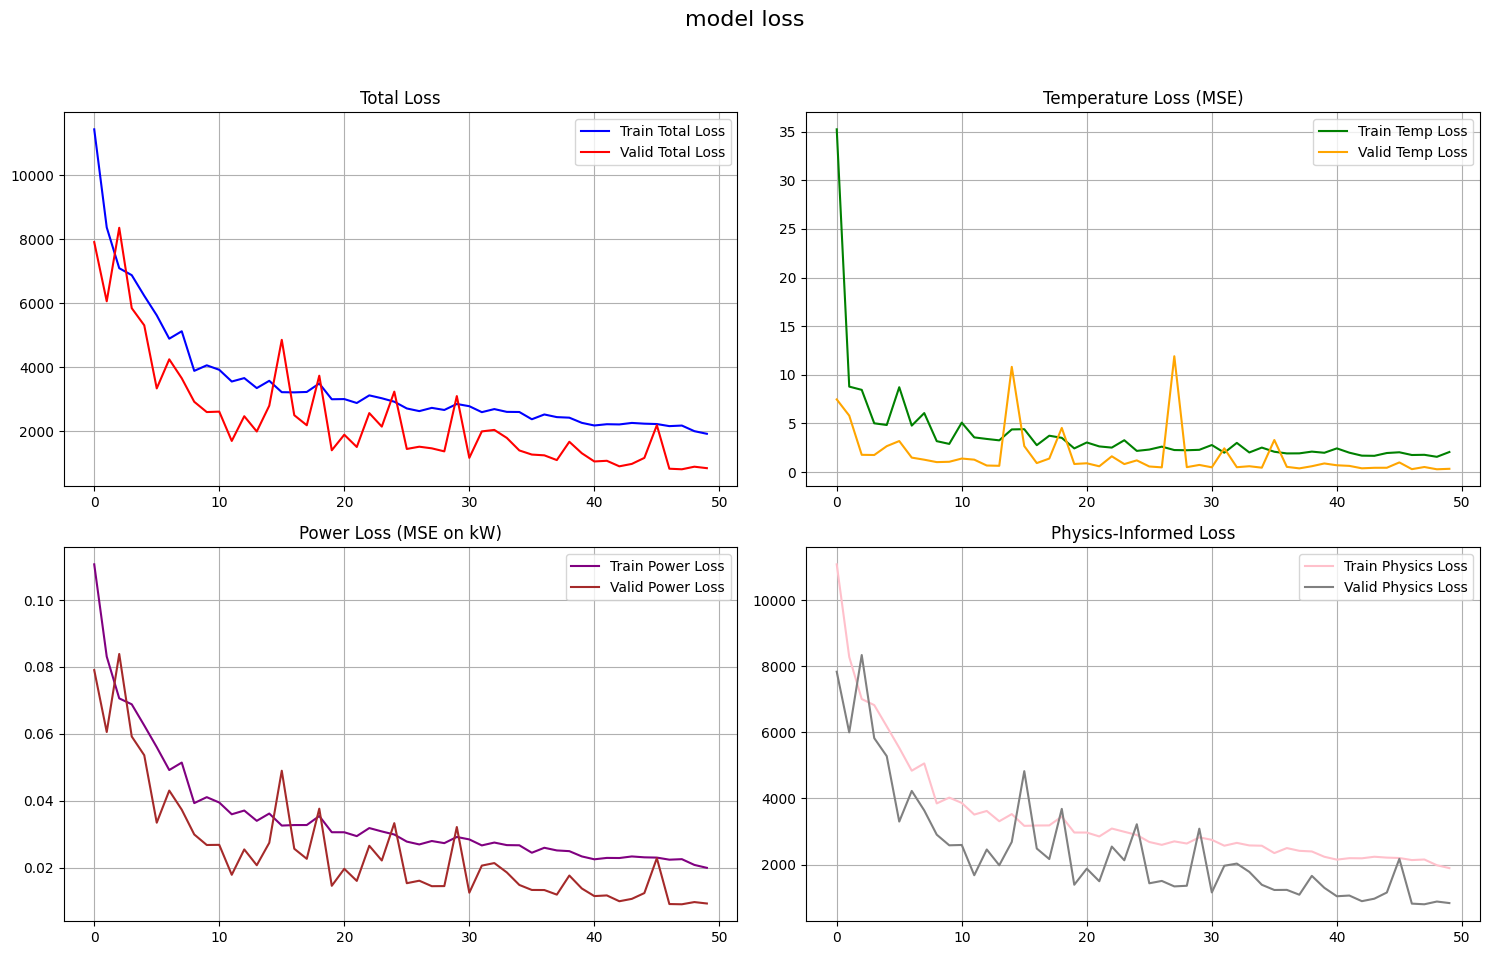

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('model loss', fontsize=16)

# 总损失
axes[0, 0].plot(train_losses['total'], label='Train Total Loss', color='blue')
axes[0, 0].plot(valid_losses['total'], label='Valid Total Loss', color='red')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 温度损失
axes[0, 1].plot(train_losses['temp'], label='Train Temp Loss', color='green')
axes[0, 1].plot(valid_losses['temp'], label='Valid Temp Loss', color='orange')
axes[0, 1].set_title('Temperature Loss (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 功率损失
axes[1, 0].plot(train_losses['power'], label='Train Power Loss', color='purple')
axes[1, 0].plot(valid_losses['power'], label='Valid Power Loss', color='brown')
axes[1, 0].set_title('Power Loss (MSE on kW)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 物理损失
axes[1, 1].plot(train_losses['physics'], label='Train Physics Loss', color='pink')
axes[1, 1].plot(valid_losses['physics'], label='Valid Physics Loss', color='gray')
axes[1, 1].set_title('Physics-Informed Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Cell 11: 优化的全程预测



成功加载模型 '../model/best_balanced_hybrid_pinn_v2.pt' 用于全程预测。
找到 4 个测试文件。开始逐文件可视化预测...


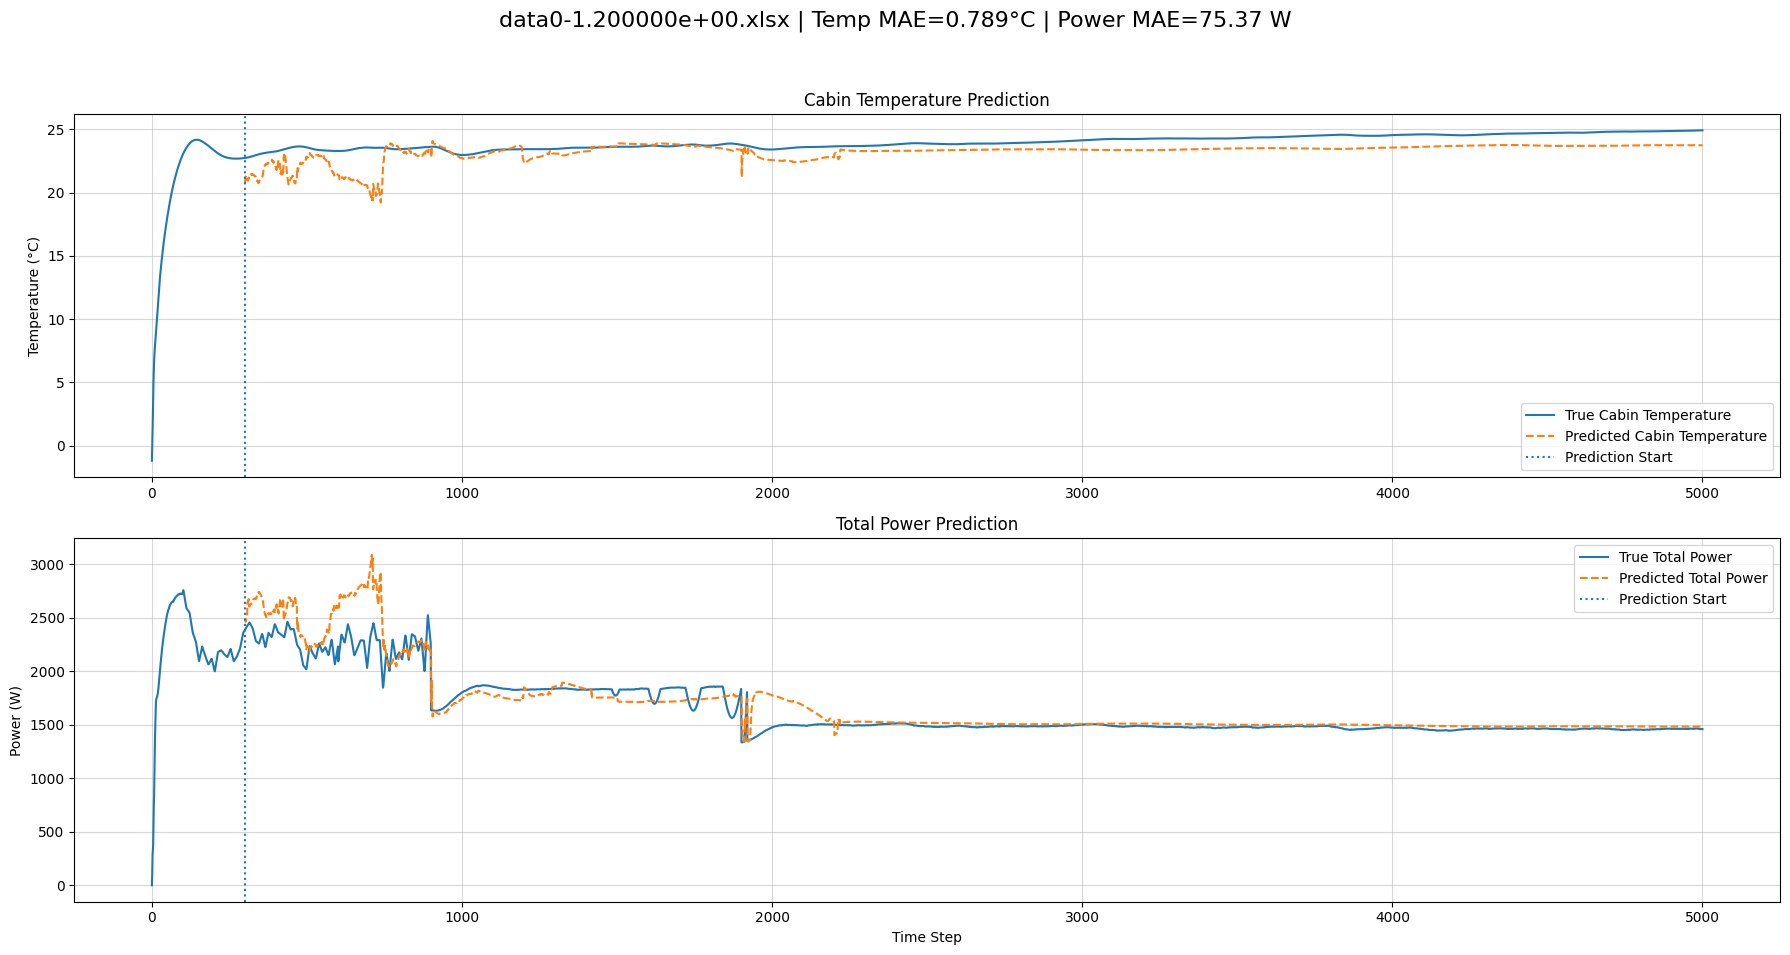

[data0-1.200000e+00.xlsx] Temperature MAE: 0.7893 °C | Power MAE: 75.3696 W


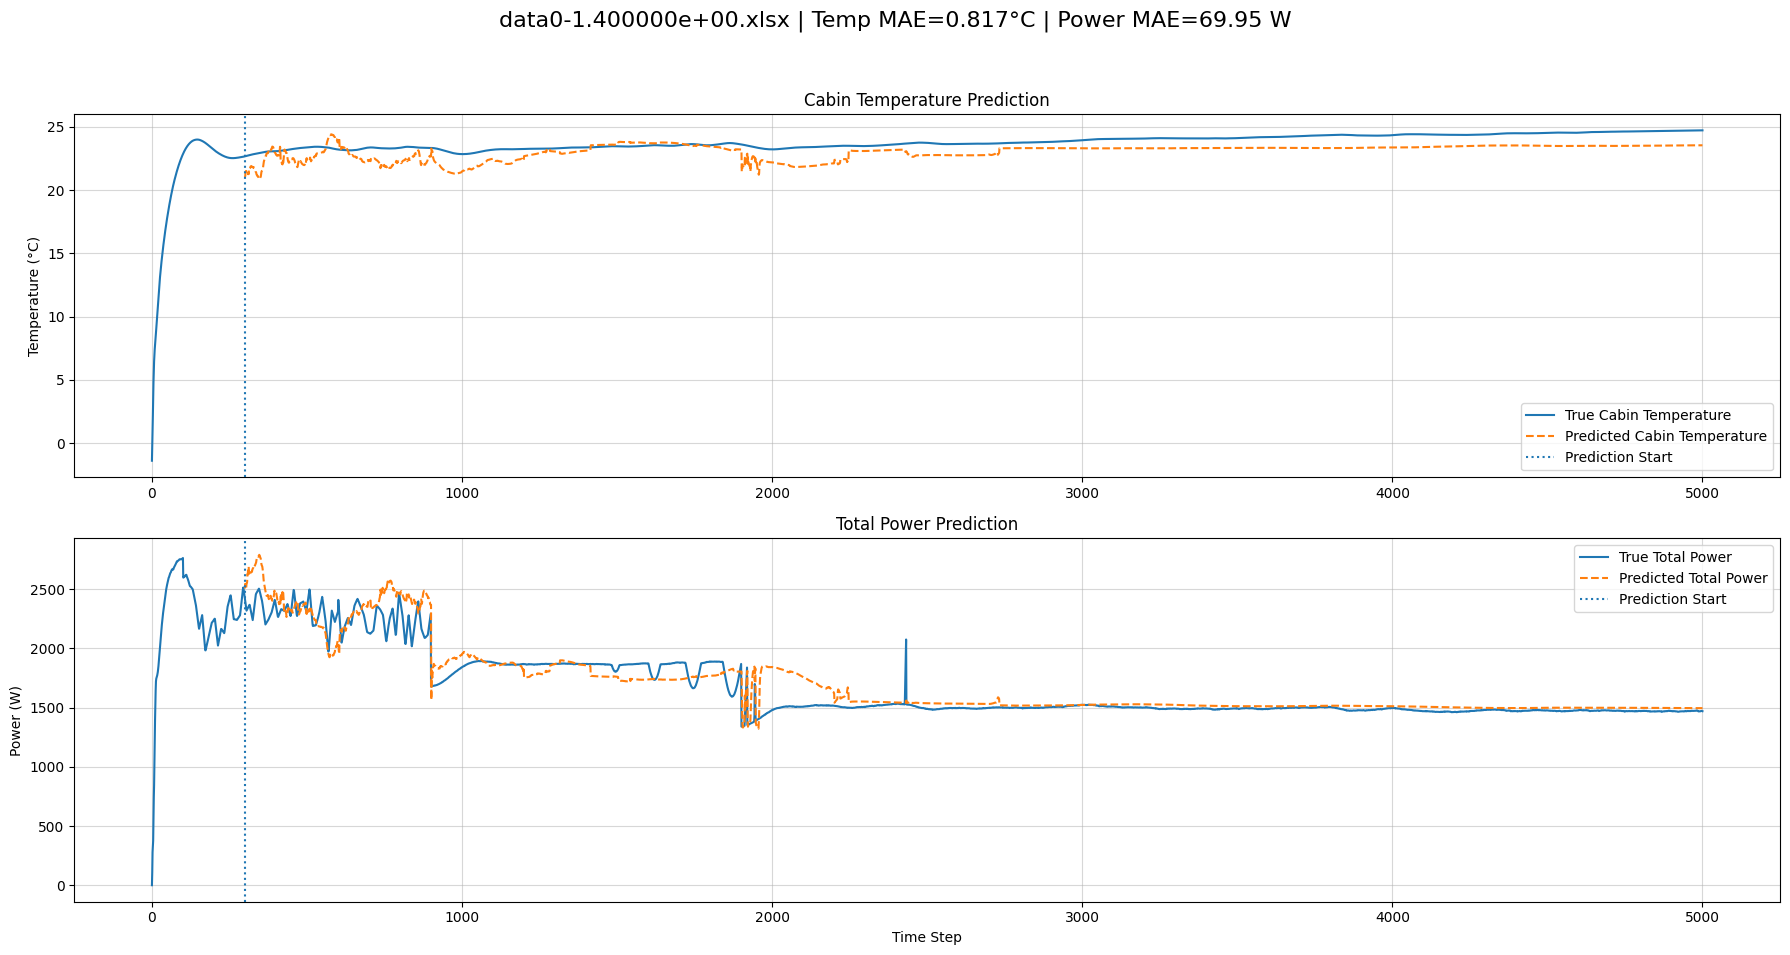

[data0-1.400000e+00.xlsx] Temperature MAE: 0.8168 °C | Power MAE: 69.9531 W


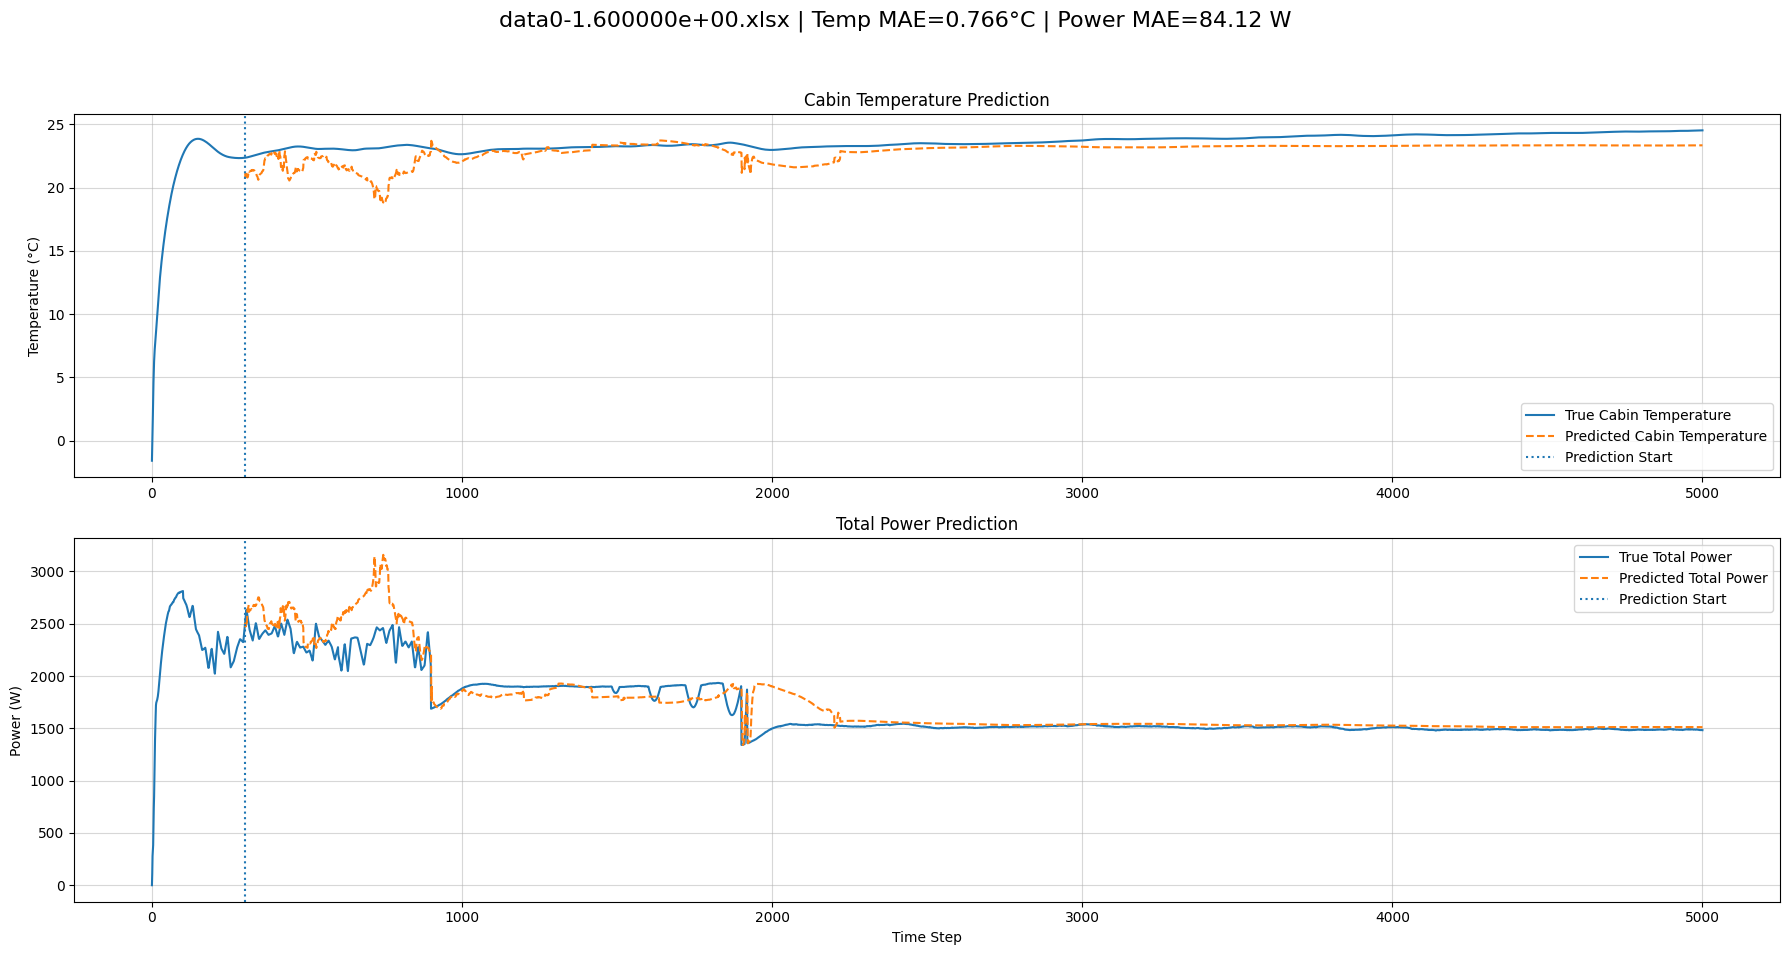

[data0-1.600000e+00.xlsx] Temperature MAE: 0.7663 °C | Power MAE: 84.1183 W


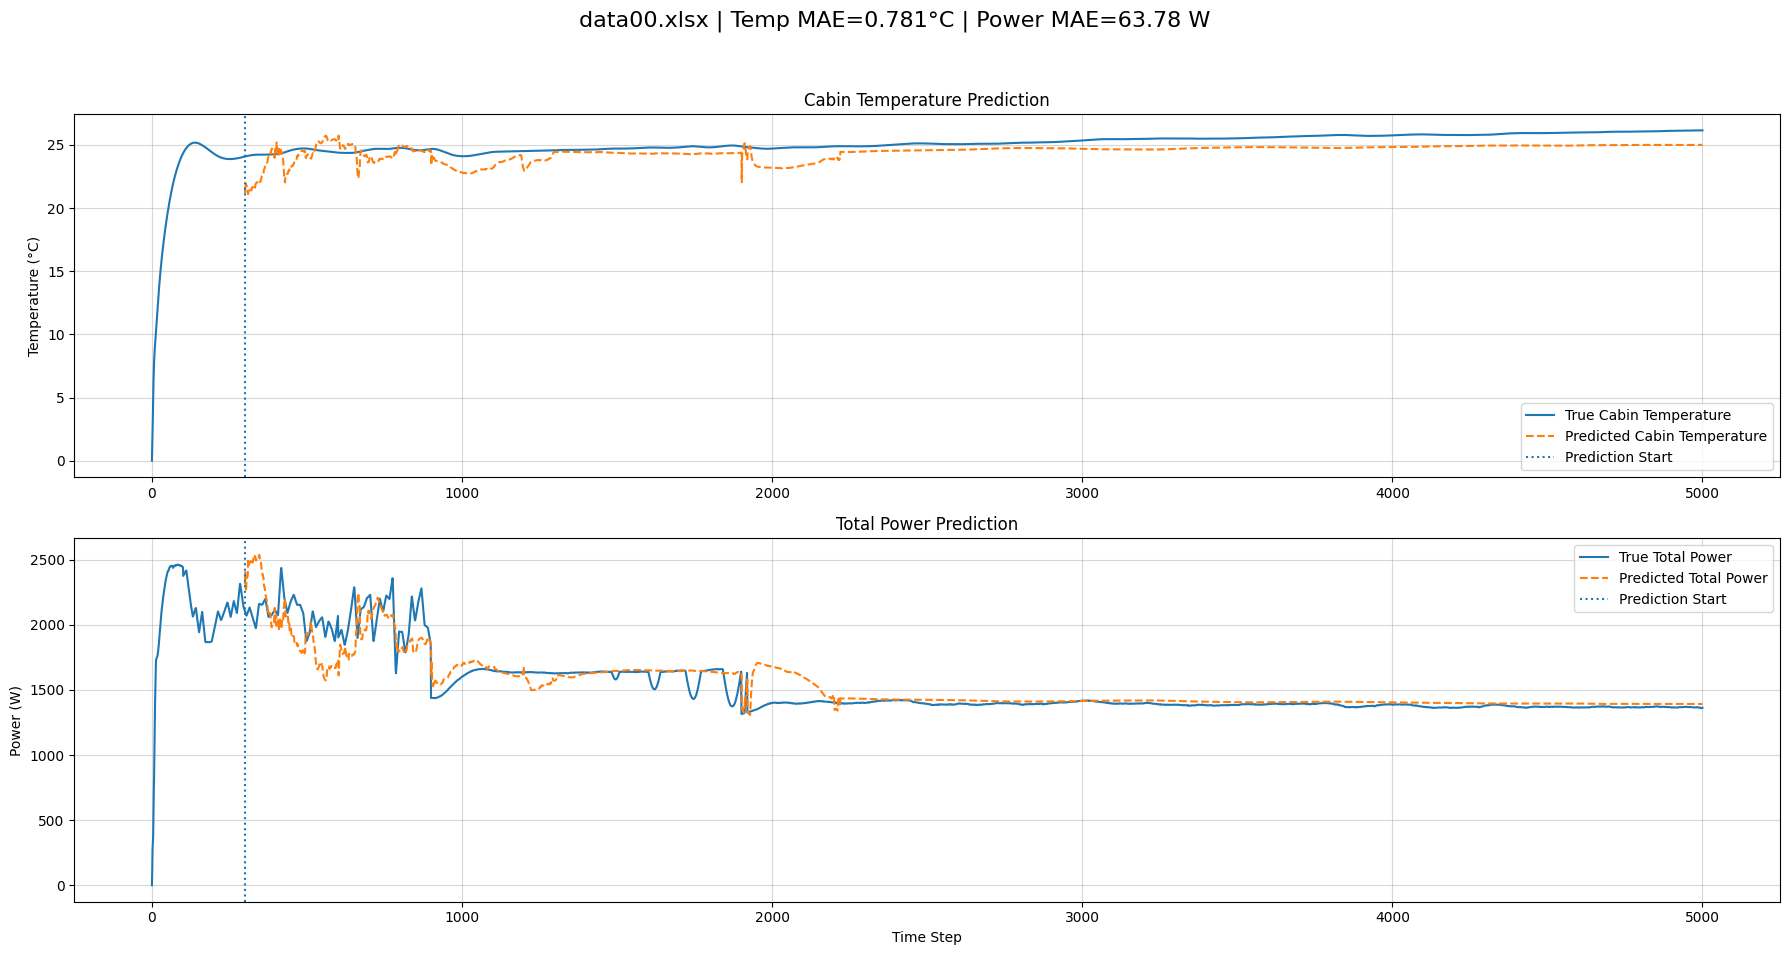

[data00.xlsx] Temperature MAE: 0.7809 °C | Power MAE: 63.7815 W


In [27]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

def create_test_features(input_window, lagged_total_power_norm, norm_stats):
    """
    为单个样本创建特征，匹配训练时的特征工程逻辑。
    input_window: numpy array, shape (sequence_length, 3) -> [ambient, ptc, compressor]
    lagged_total_power_norm: numpy array, shape (sequence_length,)
    """
    # 1. 基础特征归一化（median/mad）
    normalized_features = np.zeros_like(input_window, dtype=np.float64)
    normalized_features[:, 0] = (input_window[:, 0] - norm_stats['median_ambient_temp']) / max(norm_stats['mad_ambient_temp'], 1e-6)
    normalized_features[:, 1] = (input_window[:, 1] - norm_stats['median_ptc_power']) / max(norm_stats['mad_ptc_power'], 1e-6)
    normalized_features[:, 2] = (input_window[:, 2] - norm_stats['median_compressor_power']) / max(norm_stats['mad_compressor_power'], 1e-6)

    # 2. 一阶差分
    diff_features = np.diff(normalized_features, axis=0, prepend=normalized_features[0:1, :])

    # 3. 滑动窗口统计特征（窗口=10）
    window_size = 10
    power_sum = normalized_features[:, 1] + normalized_features[:, 2]
    power_ratio = np.divide(normalized_features[:, 1], normalized_features[:, 2] + 1e-6)
    power_sum_ma = pd.Series(power_sum).rolling(window=window_size, min_periods=1).mean().values
    power_ratio_ma = pd.Series(power_ratio).rolling(window=window_size, min_periods=1).mean().values

    # 4. 物理启发特征
    temp_gradient = np.gradient(normalized_features[:, 0])
    power_change_rate = np.gradient(power_sum)

    # 5. 滞后总功率特征（传入的规范值）
    # lagged_total_power_norm shape: (sequence_length,)

    # 6. 组合 11 个特征
    combined_features = np.column_stack([
        normalized_features,          # 3
        diff_features,                # 3
        power_sum_ma,                 # 1
        power_ratio_ma,               # 1
        temp_gradient,                # 1
        power_change_rate,            # 1
        lagged_total_power_norm       # 1
    ])
    return combined_features


# --- 开始全程预测（只可视化，不保存） ---
model_save_path = '../model/best_balanced_hybrid_pinn_v2.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    checkpoint = torch.load(model_save_path, map_location=device)
    model = DynamicDecoupledHybridPINN(input_size=11, hidden_size=256, num_layers=3, dropout=0.1).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    norm_stats = checkpoint['normalization_stats']
    model.eval()
    print(f"\n成功加载模型 '{model_save_path}' 用于全程预测。")
except FileNotFoundError:
    print(f"警告: 未找到模型 '{model_save_path}'，无法预测。")
    norm_stats = None

# 测试数据文件夹
test_data_directory = r"../data/test"
excel_files = [f for f in os.listdir(test_data_directory) if f.startswith('data') and f.endswith('.xlsx')]
excel_files.sort()

sequence_length = 300  # 输入窗口长度

if norm_stats is None or not excel_files:
    print("未能进行全程预测：请检查模型文件/测试文件是否存在。")
else:
    print(f"找到 {len(excel_files)} 个测试文件。开始逐文件可视化预测...")

    for file_name in excel_files:
        file_path = os.path.join(test_data_directory, file_name)
        df = pd.read_excel(file_path)

        required_cols = ['Ambient Temperature', 'PTC Power', 'Compressor Power', 'Cabin Temperature', 'Total Power']
        if any(col not in df.columns for col in required_cols):
            print(f"跳过 {file_name}: 缺少必要列 {required_cols}")
            continue

        data_arrays = [df[col].values for col in required_cols]
        min_len = min(len(arr) for arr in data_arrays)
        ambient_temp, ptc_power, compressor_power, cabin_temp_true, total_power_true = [arr[:min_len] for arr in data_arrays]

        if min_len < sequence_length + 1:
            print(f"跳过 {file_name}: 数据长度 {min_len} 小于 {sequence_length + 1}")
            continue

        input_data_raw = np.column_stack([ambient_temp, ptc_power, compressor_power])

        temp_predictions, power_predictions = [], []

        # 初始化滞后总功率（初始用真实）
        lagged_total_power = np.roll(total_power_true[:sequence_length], 1)
        lagged_total_power[0] = 0.0
        lagged_total_power_norm = (lagged_total_power - norm_stats['median_total_power']) / max(norm_stats['mad_total_power'], 1e-6)

        for i in range(min_len - sequence_length):
            input_window = input_data_raw[i: i + sequence_length]

            features = create_test_features(input_window, lagged_total_power_norm, norm_stats)
            input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                temp_pred, power_pred = model(input_tensor)

            # 取最后一个时间步的预测值
            predicted_temp_value = temp_pred[0, -1, 0].item()
            predicted_power_value = power_pred[0, -1, 0].item()

            temp_predictions.append(predicted_temp_value)
            power_predictions.append(predicted_power_value)

            # 自回归更新：用预测功率更新下一滞后（移位并添加新预测）
            lagged_total_power = np.roll(lagged_total_power, -1)
            lagged_total_power[-1] = predicted_power_value
            lagged_total_power_norm = (lagged_total_power - norm_stats['median_total_power']) / max(norm_stats['mad_total_power'], 1e-6)

        time_steps = np.arange(min_len)
        pred_time_steps = time_steps[sequence_length:]

        # MAE（仅用于展示/打印）
        temp_mae_file = np.mean(np.abs(np.array(temp_predictions) - cabin_temp_true[sequence_length:]))
        power_mae_file = np.mean(np.abs(np.array(power_predictions) - total_power_true[sequence_length:]))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
        fig.suptitle(
            f'{file_name} | Temp MAE={temp_mae_file:.3f}°C | Power MAE={power_mae_file:.2f} W',
            fontsize=16
        )

        ax1.plot(time_steps, cabin_temp_true, label='True Cabin Temperature')
        ax1.plot(pred_time_steps, temp_predictions, label='Predicted Cabin Temperature', linestyle='--')
        ax1.axvline(x=sequence_length, linestyle=':', label='Prediction Start')
        ax1.set_title('Cabin Temperature Prediction')
        ax1.set_ylabel('Temperature (°C)')
        ax1.legend()
        ax1.grid(True, alpha=0.5)

        ax2.plot(time_steps, total_power_true, label='True Total Power')
        ax2.plot(pred_time_steps, power_predictions, label='Predicted Total Power', linestyle='--')
        ax2.axvline(x=sequence_length, linestyle=':', label='Prediction Start')
        ax2.set_title('Total Power Prediction')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Power (W)')
        ax2.legend()
        ax2.grid(True, alpha=0.5)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"[{file_name}] Temperature MAE: {temp_mae_file:.4f} °C | Power MAE: {power_mae_file:.4f} W")
